In [5]:
import os
import time 

import torch
from torchvision import datasets, transforms

### helper functions

In [6]:
# define helper.py 
import matplotlib.pyplot as plt
import numpy as np
from torch import nn, optim
from torch.autograd import Variable


def test_network(net, trainloader):

    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)

    dataiter = iter(trainloader)
    images, labels = dataiter.next()

    # Create Variables for the inputs and targets
    inputs = Variable(images)
    targets = Variable(images)

    # Clear the gradients from all Variables
    optimizer.zero_grad()

    # Forward pass, then backward pass, then update weights
    output = net.forward(inputs)
    loss = criterion(output, targets)
    loss.backward()
    optimizer.step()

    return True

def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax


def view_recon(img, recon):
    ''' Function for displaying an image (as a PyTorch Tensor) and its
        reconstruction also a PyTorch Tensor
    '''

    fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True)
    axes[0].imshow(img.numpy().squeeze())
    axes[1].imshow(recon.data.numpy().squeeze())
    for ax in axes:
        ax.axis('off')
        ax.set_adjustable('box-forced')


### Load the dataset

In [46]:
dataset = datasets.ImageFolder('/home/tamil/.cache/kagglehub/datasets/alessiocorrado99/animals10/versions/2/raw-img')

In [47]:
# train, test split
train_ratio = 0.8
train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size

train_data, test_data = torch.utils.data.random_split(dataset, [train_size, test_size])

In [48]:
# apply transforms on the split dataset
train_data.dataset.transform = transforms.Compose([transforms.RandomRotation(30),
                                                  transforms.RandomResizedCrop(224),
                                                  transforms.RandomHorizontalFlip(),
                                                  transforms.ToTensor()])

test_data.dataset.transform = transforms.Compose([transforms.RandomRotation(30),
                                     transforms.RandomResizedCrop(224),
                                     transforms.ToTensor()])

In [49]:
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False)

#### Verifying the dataset

In [50]:
data, target = next(iter(train_dataloader))
print("Data shape:", data.shape)
print("Target shape:", target.shape)
print(target)

Data shape: torch.Size([32, 3, 224, 224])
Target shape: torch.Size([32])
tensor([2, 2, 1, 8, 2, 7, 4, 2, 4, 6, 0, 7, 9, 3, 6, 9, 2, 4, 3, 8, 7, 6, 5, 9,
        8, 1, 0, 4, 8, 8, 3, 6])


In [51]:
train_dataset = train_dataloader.dataset.dataset
all_labels = train_dataset.targets    # e.g. [0, 5, 3, 0, 1, …]
class_names = train_dataset.classes   # e.g. ["cat","dog","elephant",…]


In [52]:
class_names

['butterfly',
 'cat',
 'chicken',
 'cow',
 'dog',
 'elephant',
 'horse',
 'sheep',
 'spider',
 'squirrel']

In [53]:
from collections import Counter

counts = Counter(all_labels)
for idx, cnt in sorted(counts.items()):
    print(f"{class_names[idx]:10s} → {cnt}")


butterfly  → 2112
cat        → 1668
chicken    → 3098
cow        → 1866
dog        → 4863
elephant   → 1446
horse      → 2623
sheep      → 1820
spider     → 4821
squirrel   → 1862


In [54]:
# assuming you built your loader from an ImageFolder:
train_dataset = train_dataloader.dataset.dataset  # or train_dataloader.dataset.dataset
class_names  = train_dataset.classes       # e.g. ["cat","dog","elephant",...]

# now print names for that batch:
for i, idx in enumerate(target):
    print(f"Image {i:2d}: index={idx.item():2d}  →  {class_names[idx]}")


Image  0: index= 2  →  chicken
Image  1: index= 2  →  chicken
Image  2: index= 1  →  cat
Image  3: index= 8  →  spider
Image  4: index= 2  →  chicken
Image  5: index= 7  →  sheep
Image  6: index= 4  →  dog
Image  7: index= 2  →  chicken
Image  8: index= 4  →  dog
Image  9: index= 6  →  horse
Image 10: index= 0  →  butterfly
Image 11: index= 7  →  sheep
Image 12: index= 9  →  squirrel
Image 13: index= 3  →  cow
Image 14: index= 6  →  horse
Image 15: index= 9  →  squirrel
Image 16: index= 2  →  chicken
Image 17: index= 4  →  dog
Image 18: index= 3  →  cow
Image 19: index= 8  →  spider
Image 20: index= 7  →  sheep
Image 21: index= 6  →  horse
Image 22: index= 5  →  elephant
Image 23: index= 9  →  squirrel
Image 24: index= 8  →  spider
Image 25: index= 1  →  cat
Image 26: index= 0  →  butterfly
Image 27: index= 4  →  dog
Image 28: index= 8  →  spider
Image 29: index= 8  →  spider
Image 30: index= 3  →  cow
Image 31: index= 6  →  horse


<Axes: >

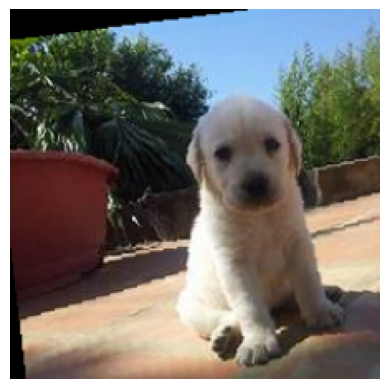

In [11]:
# test the data loader
images, labels = next(iter(train_dataloader))
imshow(images[0], normalize=False)

### Training the model

In [55]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

In [56]:
model = models.densenet121(pretrained=True)
model

/home/tamil/DL-animal-10/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/tamil/DL-animal-10/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [57]:
# freezing the parameters

for param in model.parameters():
    param.requires_grad = False

from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                            ('fc1', nn.Linear(1024, 500)),
                            ('relu1', nn.ReLU()),
                            ('fc2', nn.Linear(500, 10)),
                            ('output', nn.LogSoftmax(dim=1))
]))

model.classifier = classifier
                             

In [58]:
# training the classifier

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr = 0.003)

model = model.to(device)

In [59]:
# registering in mlflow

import mlflow
import mlflow.pytorch

mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("animal_classifier")



<Experiment: artifact_location='mlflow-artifacts:/371523339529422074', creation_time=1749724822291, experiment_id='371523339529422074', last_update_time=1749724822291, lifecycle_stage='active', name='animal_classifier', tags={}>

In [60]:
epochs = 1
print_every = 5


hyperparams = {
    "epochs": epochs,
    "print_every": print_every,
    "optimizer": optimizer.__class__.__name__,
    "lr": optimizer.param_groups[0]['lr'],
    "criterion": criterion.__class__.__name__
}

with mlflow.start_run(run_name = "run_2"):

    mlflow.log_params(hyperparams)

    steps = 0
    running_loss = 0
    
    for epoch in range(epochs):
        start = time.perf_counter()
        model.train()
        
        for inputs, labels in train_dataloader:
            steps += 1
            inputs, labels = inputs.to(device), labels.to(device)
    
            optimizer.zero_grad()
    
            logps = model.forward(inputs)
            loss = criterion(logps, labels)
    
            loss.backward()
            optimizer.step()
    
            running_loss += loss.item()
    
            if steps % print_every == 0:
                model.eval()
                test_loss = 0
                accuracy = 0 
                
                with torch.no_grad():
                    for inputs, labels in test_dataloader:
                        inputs, labels = inputs.to(device), labels.to(device)
    
                        logps = model.forward(inputs)
                        batch_loss = criterion(logps, labels)
    
                        test_loss += batch_loss.item()
                        ps = torch.exp(logps)
    
                        top_p, top_class = ps.topk(1, dim = 1)
                        equals = top_class == labels.view(*top_class.shape)
                        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                
                elapsed = time.perf_counter() - start

                # 2) Build a quick grid of, say, the first 4 images in this batch
                fig, axes = plt.subplots(2, 2, figsize=(8, 8))
                preds = model(inputs).argmax(1).cpu()
                for i, ax in enumerate(axes.flatten()):
                    img = inputs[i].cpu().permute(1, 2, 0)  # C×H×W → H×W×C
                    ax.imshow(img)
                    ax.set_title(f"True: {labels[i].item()}  Pred: {preds[i].item()}")
                    ax.axis("off")
                plt.tight_layout()
    
                # 3) Log that figure to MLflow under this run
                mlflow.log_figure(fig, f"batch_{steps:04d}_preds.png")
                plt.close(fig)
                
                # Log metrics to MLflow
                mlflow.log_metric("train_loss", running_loss, step=steps)
                mlflow.log_metric("test_loss", test_loss / len(test_dataloader), step=steps)
                mlflow.log_metric("accuracy", accuracy / len(test_dataloader), step=steps)
                mlflow.log_metric("epoch_time_s", elapsed, step=steps)

                print(f"Epoch {epoch+1}/{epochs} took {elapsed:.2f} s;"
                      f"Train_loss: {running_loss};"
                      f"Test_loss: {test_loss/len(test_dataloader):.3f}; "
                      f"Accuracy: {accuracy/len(test_dataloader):.3f}")
                running_loss = 0
                model.train()

Epoch 1/1 took 273.52 s;Train_loss: 14.977712392807007;Test_loss: 2.382; Accuracy: 0.282
Epoch 1/1 took 544.68 s;Train_loss: 11.271865129470825;Test_loss: 1.817; Accuracy: 0.588
Epoch 1/1 took 821.76 s;Train_loss: 8.56601071357727;Test_loss: 1.520; Accuracy: 0.506
Epoch 1/1 took 1093.53 s;Train_loss: 7.625591516494751;Test_loss: 1.306; Accuracy: 0.614
Epoch 1/1 took 1365.37 s;Train_loss: 5.590782046318054;Test_loss: 1.052; Accuracy: 0.691
Epoch 1/1 took 1636.32 s;Train_loss: 4.78546667098999;Test_loss: 0.789; Accuracy: 0.757
Epoch 1/1 took 1917.18 s;Train_loss: 4.450887441635132;Test_loss: 0.683; Accuracy: 0.800
Epoch 1/1 took 2184.37 s;Train_loss: 3.2071914076805115;Test_loss: 0.604; Accuracy: 0.813
🏃 View run run_2 at: http://localhost:5000/#/experiments/371523339529422074/runs/9cd80b55e0e8437ebffe03292d958106
🧪 View experiment at: http://localhost:5000/#/experiments/371523339529422074


KeyboardInterrupt: 